In [16]:
import glob
import torch
import os
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.ticker as mticker
from sklearn.mixture import GaussianMixture
from copy import copy

from src.utils.pickle_handler import *
from src.models.mixtures.squared_nm_gaussian_mixture import NMSquaredGaussianMixture

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
# Load dataset
train_set = load_object('data/train', 'banana')
val_set = load_object('data/val', 'banana')

tensor_train_set = torch.from_numpy(train_set) if str(device) == 'cpu' else torch.from_numpy(train_set).cuda()
tensor_val_set = torch.from_numpy(val_set) if str(device) == 'cpu' else torch.from_numpy(val_set).cuda()

In [19]:
# Train and fit baseline

# Create an instance of the GaussianMixture class
n_components = 4 # number of Gaussian components
gmm_0 = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    init_params='random_from_data'
)
gmm = copy(gmm_0)

baseline_train_loss = []
baseline_val_loss = []

for i in range(20): 
    if i == 0:
        gmm_0 = gmm_0.fit(train_set)
    gmm = gmm.fit(train_set)
    
    baseline_train_loss.append(-gmm.score(train_set))
    baseline_val_loss.append(-gmm.score(val_set))
    
# Print the negative log likelihood for each iteration step

print(-gmm.score(train_set))
print(-gmm_0.score(train_set))

3.54269140874986
3.5487488358753065


In [21]:
# Load models
path_it0 = 'out/saved_models/checkpoint0_nm_banana'
path_it19= 'out/saved_models/checkpoint19_nm_banana'

model_it0 = NMSquaredGaussianMixture(2, 2)
model_it0.load_state_dict(state_dict=torch.load(path_it0))

model_it19 = NMSquaredGaussianMixture(2, 2)
model_it19.load_state_dict(state_dict=torch.load(path_it19))

model_it0.neglog_likelihood(tensor_train_set)
model_it19.neglog_likelihood(tensor_train_set)

tensor(-0.0006, dtype=torch.float64, grad_fn=<NegBackward0>)

In [22]:
model_it0.tb_params

{'means': tensor([[-1.9144e-04,  7.9627e+00],
         [-1.8887e-04,  6.9373e+00],
         [-1.8887e-04,  6.9373e+00],
         [-1.4334e-04,  4.9715e+00]], dtype=torch.float64,
        grad_fn=<StackBackward0>),
 'sigmas': tensor([[[4.5026e+00, 2.9612e-04],
          [2.9612e-04, 1.2769e+01]],
 
         [[6.2144e+00, 3.0336e-04],
          [3.0336e-04, 1.6782e+01]],
 
         [[6.2144e+00, 3.0336e-04],
          [3.0336e-04, 1.6782e+01]],
 
         [[1.0026e+01, 1.6364e-04],
          [1.6364e-04, 2.4477e+01]]], dtype=torch.float64,
        grad_fn=<StackBackward0>),
 'weights': tensor([0.1329, 0.2331, 0.2331, 0.4089], dtype=torch.float64,
        grad_fn=<StackBackward0>)}

In [23]:
# Load train and val loss data
train_loss_vis = load_object('out/models/nm_banana', 'train_loss_vis')
val_loss_vis = load_object('out/models/nm_banana', 'val_loss_vis')
train_loss_vis

[[tensor(0.0810, dtype=torch.float64, requires_grad=True),
  tensor(0.0794, dtype=torch.float64, requires_grad=True),
  tensor(0.0799, dtype=torch.float64, requires_grad=True),
  tensor(0.0807, dtype=torch.float64, requires_grad=True),
  tensor(0.0781, dtype=torch.float64, requires_grad=True),
  tensor(0.0778, dtype=torch.float64, requires_grad=True),
  tensor(0.0773, dtype=torch.float64, requires_grad=True),
  tensor(0.0784, dtype=torch.float64, requires_grad=True),
  tensor(0.0779, dtype=torch.float64, requires_grad=True),
  tensor(0.0767, dtype=torch.float64, requires_grad=True),
  tensor(0.0780, dtype=torch.float64, requires_grad=True),
  tensor(0.0796, dtype=torch.float64, requires_grad=True),
  tensor(0.0785, dtype=torch.float64, requires_grad=True),
  tensor(0.0795, dtype=torch.float64, requires_grad=True),
  tensor(0.0799, dtype=torch.float64, requires_grad=True),
  tensor(0.0756, dtype=torch.float64, requires_grad=True),
  tensor(0.0798, dtype=torch.float64, requires_grad=True

In [388]:
val_loss_vis

[[tensor(0.4178, dtype=torch.float64),
  tensor(0.4161, dtype=torch.float64),
  tensor(0.4209, dtype=torch.float64),
  tensor(0.4138, dtype=torch.float64),
  tensor(0.4223, dtype=torch.float64),
  tensor(0.4157, dtype=torch.float64),
  tensor(0.4151, dtype=torch.float64),
  tensor(0.4162, dtype=torch.float64),
  tensor(0.4213, dtype=torch.float64),
  tensor(0.4152, dtype=torch.float64),
  tensor(0.4093, dtype=torch.float64),
  tensor(0.4285, dtype=torch.float64),
  tensor(0.4197, dtype=torch.float64),
  tensor(0.4184, dtype=torch.float64),
  tensor(0.4104, dtype=torch.float64),
  tensor(0.4261, dtype=torch.float64),
  tensor(0.4289, dtype=torch.float64),
  tensor(0.4197, dtype=torch.float64),
  tensor(0.4181, dtype=torch.float64),
  tensor(0.4114, dtype=torch.float64),
  tensor(0.4154, dtype=torch.float64),
  tensor(0.4175, dtype=torch.float64),
  tensor(0.4138, dtype=torch.float64),
  tensor(0.4225, dtype=torch.float64),
  tensor(0.4187, dtype=torch.float64),
  tensor(0.4207, dtype=to

In [24]:
def _confidence_ellipse(ax, sigma, mu, n_std=2.3, facecolor='none', **kwargs):
        pearson = sigma[0][1]/np.sqrt(sigma[0][0] * sigma[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(sigma[0][0]) * n_std
        mean_x = mu[0]

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(sigma[1][1]) * n_std
        mean_y = mu[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def get_grid(r, i, j, cond):
        grid = np.meshgrid(r,r)

        grid = np.stack(grid,2)
        grid = grid.reshape(-1,2)
        
        num_point = len(grid)
        grid_cond = np.tile(cond[None,:], [num_point, 1])
        
        grid_cond[:,i] = grid[:,0]
        grid_cond[:,j] = grid[:,1]

        return grid_cond

def plot_heatmap(model, ax, fig):
    idx_i, idx_j = 0,1

    ngrid = 100
    eval_grid = np.linspace(-8,8,ngrid)

    cond_values = np.zeros(2)
    epsilon = 1.5

    eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


    logpdf = model.pdf(torch.from_numpy(eval_points)).data.cpu().numpy()
    
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    
    asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
    ax.set_aspect(asp)

    c = ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=0)
    #ax.scatter(train_samples[:,idx_i].data.cpu().numpy(), train_samples[:,idx_j].data.cpu().numpy(), 1, color="r", alpha=0.5)
    #ax.scatter(val_samples[:,idx_i].data.cpu().numpy(), val_samples[:,idx_j].data.cpu().numpy(), 1, color="k", alpha=0.5)


    #fig.colorbar(c, ax=ax)
    

def plot_baseline_heatmap(model, ax, fig):
    idx_i, idx_j = 0,1

    ngrid = 100
    eval_grid = np.linspace(-8,8,ngrid)

    cond_values = np.zeros(2)
    epsilon = 1.5
    
    eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)
    logpdf = []
    
    for point in eval_points:
        logpdf.append(model.score([point]))
    
    logpdf = np.exp(np.array(logpdf))
    
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    
    asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
    ax.set_aspect(asp)

    c = ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=0)
    
    
def plot_contours(model, ax):
    samples = tensor_train_set

    x, y = samples[:,0], samples[:,1]

    ax.axvline(c='grey', lw=1, alpha=.5)
    ax.axhline(c='grey', lw=1, alpha=.5)
    
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    
    asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
    ax.set_aspect(asp)
    
    ax.scatter(x, y, s=0.5)

    for i in range(len(model.tb_params['means'])):
        sigma = model.tb_params['sigmas'][i].data.cpu().numpy()
        mu = model.tb_params['means'][i].data.cpu().numpy()

        colour = 'blue' if model.tb_params['weights'][i] > 0 else 'red'
        config = {
            'edgecolor': colour,
            'facecolor': colour,
            'alpha': .1
        }

        _confidence_ellipse(ax, sigma, mu, **config)
        ax.scatter(mu[0], mu[1], c='red', s=3)

def plot_baseline_contours(model, ax):
    samples = tensor_train_set

    x, y = samples[:,0], samples[:,1]

    ax.axvline(c='grey', lw=1, alpha=.5)
    ax.axhline(c='grey', lw=1, alpha=.5)
    
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    
    asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
    ax.set_aspect(asp)
    
    ax.scatter(x, y, s=0.5)

    for i in range(len(model.means_)):
        #sigma = np.diag(model.covariances_[i])
        sigma = model.covariances_[i]
        mu = model.means_[i]

        config = {
            'edgecolor': 'blue',
            'facecolor': 'blue',
            'alpha': .1
        }

        _confidence_ellipse(ax, sigma, mu, **config)
        ax.scatter(mu[0], mu[1], c='red', s=3)

def plot_loss_curves(ax):
    train_vis = []
    val_vis = []
    
    for batch in train_loss_vis:
        batch = torch.tensor(batch).detach().numpy()
        
        train_vis.append([
            batch.min(),
            batch.max(),
            batch.mean()
        ])
    
    for batch in val_loss_vis:
        batch = torch.tensor(batch).detach().numpy()
        
        val_vis.append([
            batch.min(),
            batch.max(),
            batch.mean()
        ])
    
    train_vis = np.array(train_vis)
    val_vis = np.array(val_vis)
    
    ax.plot(list(range(1, 21)), train_vis[:,2], c='blue', label='train loss')
    ax.plot(list(range(1, 21)), val_vis[:,2], c='brown', label='val loss', linestyle='--')
    
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    ax.grid()

def plot_baseline_loss_curves(ax):
    train_vis = []
    val_vis = []
    
    ax.plot(list(range(1, 21)), baseline_train_loss, c='blue', label='train loss')
    ax.plot(list(range(1, 21)), baseline_val_loss, c='brown', label='val loss', linestyle='--')
    
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    ax.grid()

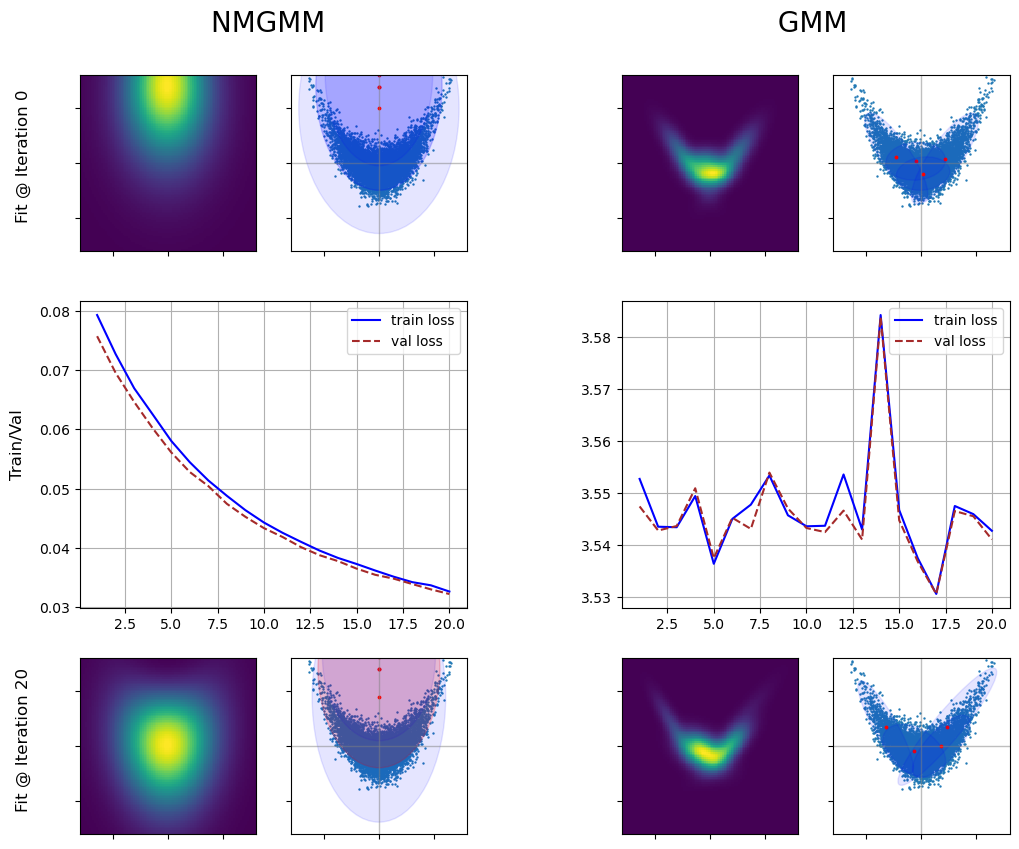

In [25]:
fig = plt.figure(figsize=(12, 10))

fig.suptitle('NMGMM                                                   GMM', y=1, fontsize=20)

gs = fig.add_gridspec(1,2,width_ratios = [6, 6], 
          height_ratios = [12], wspace=0.4)


gs0 = gs[0, 0].subgridspec(3, 2, wspace=0.2, hspace=-0.05)
gs1 = gs[0, 1].subgridspec(3, 2, wspace=0.2, hspace=-0.05)


# NMGMM Axes

ax1 = fig.add_subplot(gs0[0, 0])
ax1.set_title('Fit @ Iteration 0', color='k', rotation='vertical',x=-0.32,y=0.13)

ax2 = fig.add_subplot(gs0[0, 1], sharey=ax1, sharex=ax1)
ax1.yaxis.set_major_formatter(mticker.NullFormatter())
ax1.xaxis.set_major_formatter(mticker.NullFormatter())

ax3 = fig.add_subplot(gs0[1, :])
ax3.set_title('Train/Val', color='k', rotation='vertical',x=-0.16,y=0.40)

ax4 = fig.add_subplot(gs0[2, 0])
ax4.set_title('Fit @ Iteration 20', color='k', rotation='vertical',x=-0.32,y=0.10)

ax5 = fig.add_subplot(gs0[2, 1], sharey=ax4, sharex=ax4)
ax4.yaxis.set_major_formatter(mticker.NullFormatter())
ax4.xaxis.set_major_formatter(mticker.NullFormatter())


# GMM Axes

ax6 = fig.add_subplot(gs1[0, 0], sharey=ax1, sharex=ax1)
ax7 = fig.add_subplot(gs1[0, 1], sharey=ax1, sharex=ax1)

ax8 = fig.add_subplot(gs1[1, :])

ax9 = fig.add_subplot(gs1[2, 0], sharey=ax1, sharex=ax1)
ax10 = fig.add_subplot(gs1[2, 1], sharey=ax1, sharex=ax1)

# NMGMM Plots

plot_heatmap(model_it0, ax1, fig)
plot_contours(model_it0, ax2)

plot_loss_curves(ax3)

plot_heatmap(model_it19, ax4, fig)
plot_contours(model_it19, ax5)

# Baseline plots

plot_baseline_heatmap(gmm_0, ax6, fig)
plot_baseline_contours(gmm_0, ax7)

plot_baseline_loss_curves(ax8)

plot_baseline_heatmap(gmm, ax9, fig)
plot_baseline_contours(gmm, ax10)

plt.subplots_adjust(top=1)
fig.savefig('banana_nmgmm_results.pdf', format='pdf', dpi=1200)